<a href="https://colab.research.google.com/github/tawiahnyt/sales-forecasting/blob/main/Synthetic_beverage_sales_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning models & preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Deep learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Time series models
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Load the dataset again in case it's not yet loaded in this environment
data_path = "ultimate_data.csv"
df = pd.read_csv(data_path)

# Convert 'Date' to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [3]:
# check for missing values
df.isnull().sum()

,0
Order_ID,0
Customer_ID,0
Customer_Type,0
Product,0
Category,0
Quantity,0
Region,0
Order_Date,0
SKU,0
Volume,0


In [4]:
df.describe()

,Quantity,Order_Date,SKU,Volume
count,19998.000000,19998,19998.000000,19998.000000
mean,22.917192,2022-07-01 14:28:02.808280832,174.843684,3974.214271
min,1.000000,2021-01-01 00:00:00,0.000000,0.000000
25%,6.000000,2021-10-02 00:00:00,87.000000,606.000000
50%,11.000000,2022-07-02 00:00:00,176.000000,1685.000000
75%,29.000000,2023-04-01 00:00:00,262.000000,3948.000000
max,100.000000,2023-12-30 00:00:00,350.000000,34452.000000
std,26.797102,NaN,101.276284,5832.489569


In [5]:
df.describe(include='object')

,Order_ID,Customer_ID,Customer_Type,Product,Category,Region
count,19998,19998,19998,19998,19998,19998
unique,19936,8622,2,98,5,8
top,ORD738352,CUS449,B2C,BalonaAnyFlavour20GSht,Milk Powder,Eastern
freq,2,10,12928,296,4122,2585


In [6]:
df.shape

(19998, 10)

# Data Visualization

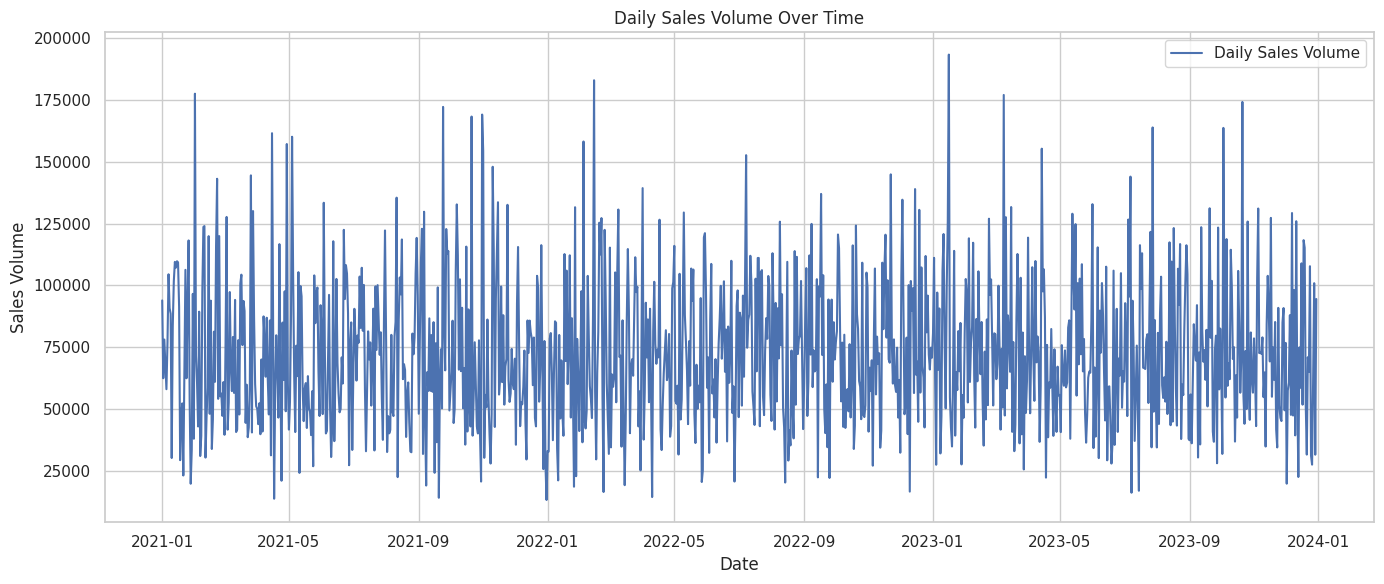

In [7]:
df = df.sort_values('Order_Date')

# Optionally aggregate by day if needed
daily_volume = df.groupby('Order_Date')['Volume'].sum().asfreq('D')

# Set plotting style
sns.set(style="whitegrid")



# Plot daily sales volume
plt.figure(figsize=(14, 6))
plt.plot(daily_volume, label='Daily Sales Volume')
plt.title('Daily Sales Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.tight_layout()
plt.show()

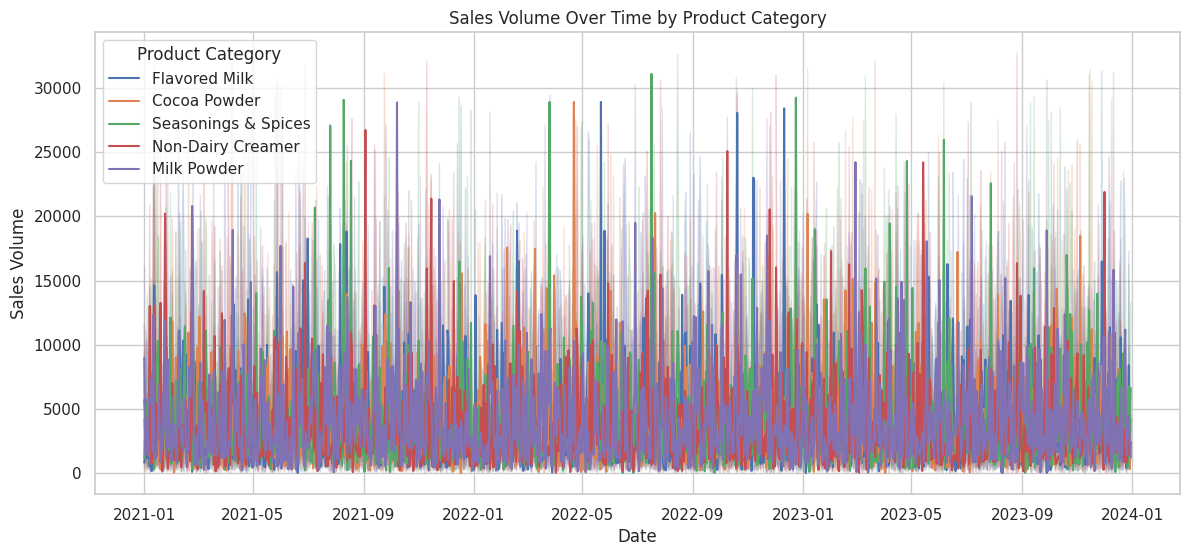

In [8]:
# Plot sales volume over time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Order_Date', y='Volume', hue='Category')
plt.title('Sales Volume Over Time by Product Category')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend(title='Product Category')
plt.show()

<ipython-input-9-092023971cb4>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Order_Date', freq='M'))['Volume'].sum().reset_index()
<ipython-input-9-092023971cb4>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = monthly_sales.asfreq('M')


<Axes: title={'center': 'Monthly Sales Over Time (Volume in Million)'}, xlabel='Date', ylabel='Sales Volume (Millions)'>

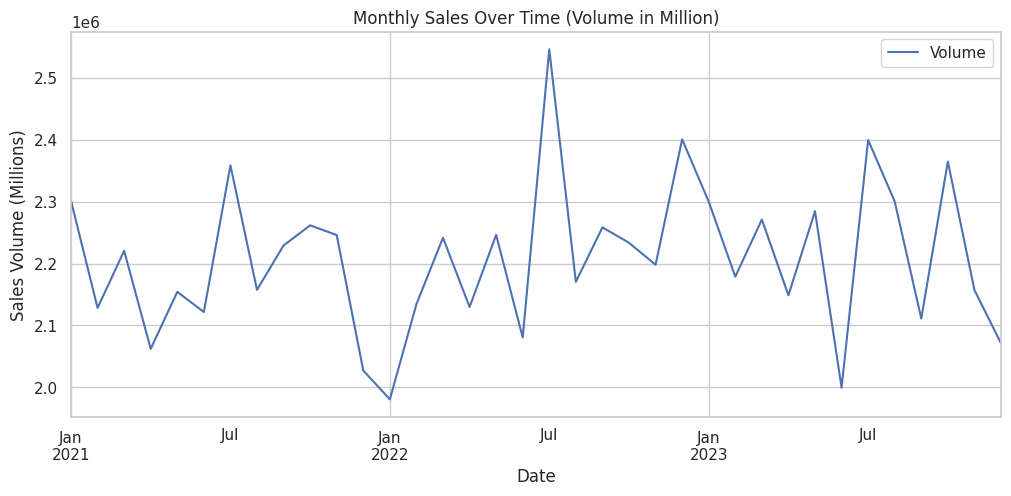

In [9]:
# Ensure date column is datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Aggregate monthly sales for all products
monthly_sales = df.groupby(pd.Grouper(key='Order_Date', freq='M'))['Volume'].sum().reset_index()

# Set date as index
monthly_sales.set_index('Order_Date', inplace=True)
monthly_sales = monthly_sales.asfreq('M')

monthly_sales.plot(title='Monthly Sales Over Time (Volume in Million)', figsize=(12,5), xlabel='Date', ylabel='Sales Volume (Millions)')

# Model Building

## ARIMA Model

In [10]:
# !pip install statsmodels
# !pip install xgboost
# !pip install tensorflow

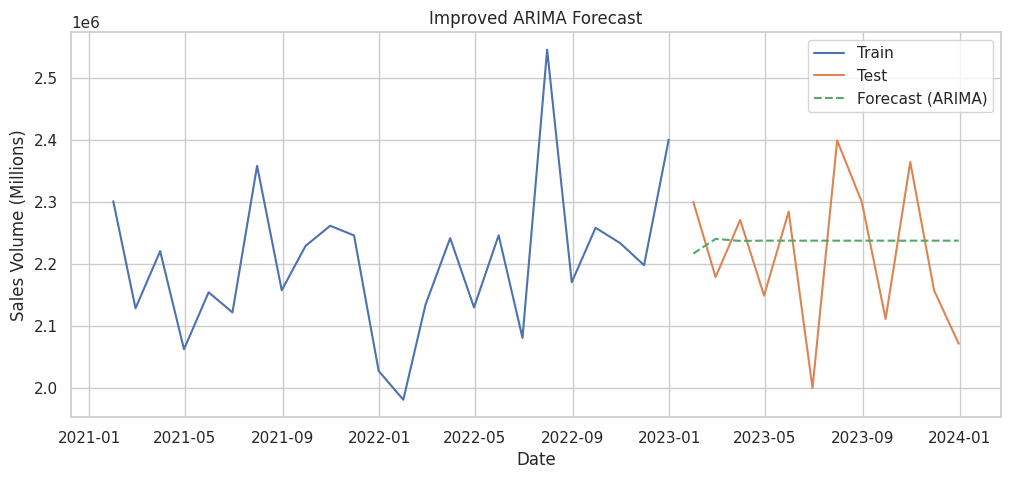

Improved ARIMA - MSE: 14598991177.59, MAE: 106488.59, R²: -0.06


In [13]:
from statsmodels.tsa.arima.model import ARIMA
train = monthly_sales[:-12]  # All data except the last 12 months for training
test = monthly_sales[-12:]   # Last 12 months for testing


# Log transform
train_log = np.log(train['Volume'])

# Fit ARIMA
model = ARIMA(train_log, order=(1,1,1))
model_fit = model.fit()

# Forecast and revert transformation
forecast_log = model_fit.forecast(steps=12)
forecast = np.exp(forecast_log)
forecast.index = test.index

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Volume'], label='Train')
plt.plot(test.index, test['Volume'], label='Test')
plt.plot(test.index, forecast, label='Forecast (ARIMA)', linestyle='--')
plt.legend()
plt.title('Improved ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

# Metrics
y_true = test['Volume'].values
c = forecast.values
mse = mean_squared_error(y_true, c)
mae = mean_absolute_error(y_true, c)
r2 = r2_score(y_true, c)

print(f"Improved ARIMA - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
#Mean Squared Error
#Mean Absolute Error
#R-squared = > 1 < > 0

#Classification = [0, 1, 2, 3] and Regression = []

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# # Train-test split
# train = monthly_sales.iloc[:-12]
# test = monthly_sales.iloc[-12:]

# # Fit ARIMA model (simple auto config)
# model = ARIMA(train, order=(1,1,1))
# model_fit = model.fit()

# # Forecast
# forecast = model_fit.forecast(steps=12)

# # Plot
# plt.figure(figsize=(12,5))
# plt.plot(train, label='Train')
# plt.plot(test, label='Test')
# plt.plot(forecast, label='Forecast (ARIMA)', linestyle='--')
# plt.legend()
# plt.title('ARIMA Forecast')
# plt.xlabel('Date')
# plt.ylabel('Sales Volume (Millions)')
# plt.show()


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Convert to numpy for metrics
# y_true_arima = test['Volume'].values
# y_pred_arima = forecast.values

# # ARIMA metrics
# mse_arima = mean_squared_error(y_true_arima, y_pred_arima)
# mae_arima = mean_absolute_error(y_true_arima, y_pred_arima)
# r2_arima = r2_score(y_true_arima, y_pred_arima)

# print(f"ARIMA - MSE: {mse_arima:.2f}, MAE: {mae_arima:.2f}, R²: {r2_arima:.2f}")

## XGBoost Model

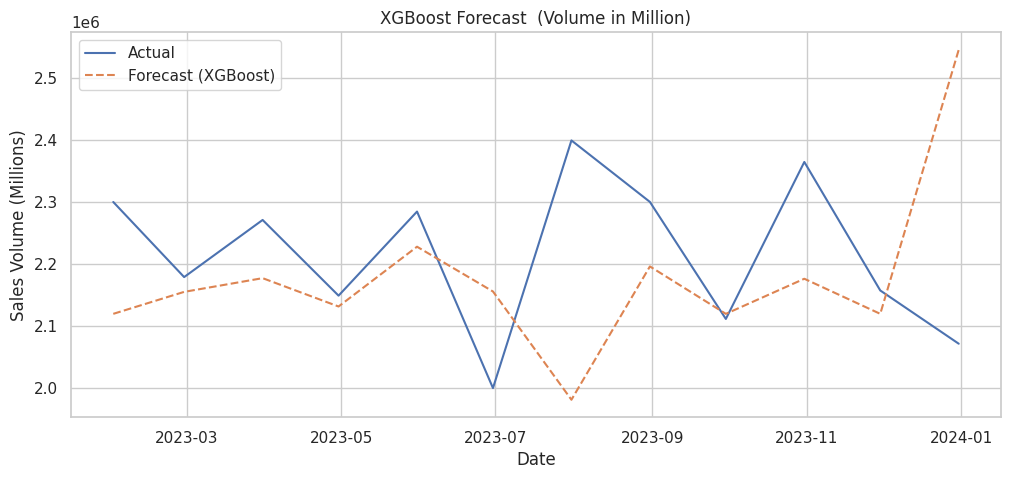

XGBoost RMSE: 207936.41366533184


In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Create lag features
df_lag = monthly_sales.copy()
for lag in range(1, 13):
    df_lag[f'lag_{lag}'] = df_lag['Volume'].shift(lag)
df_lag.dropna(inplace=True)

# Split data
X = df_lag.drop(columns='Volume')
y = df_lag['Volume']

X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

# Fit XGBoost
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

# Predict
preds = model_xgb.predict(X_test)

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.title('XGBoost Forecast  (Volume in Million)')
plt.show()

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


## LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
LSTM Performance:
MSE: 14861116634.48, MAE: 106146.21, R²: -0.07


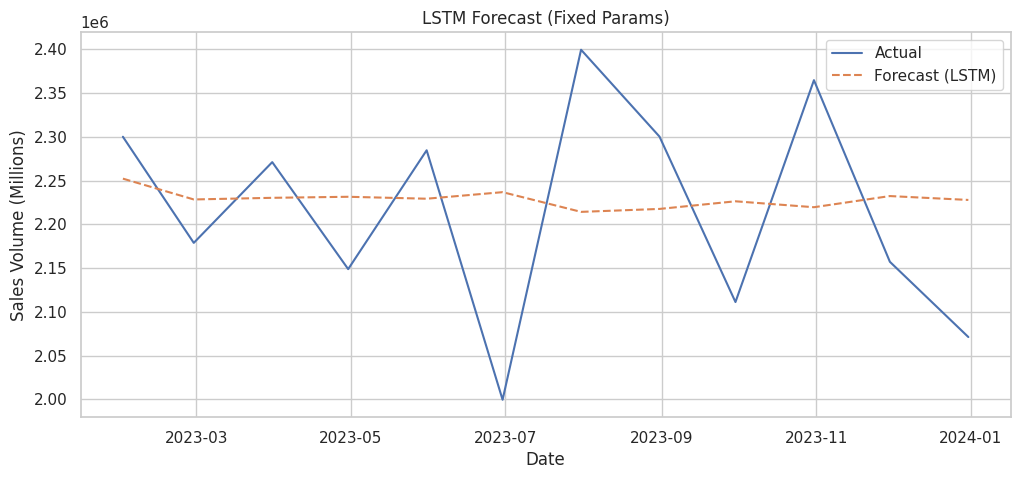

In [15]:
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fix randomness
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds()

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_sales)

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Parameters
seq_len = 6
units = 100
epochs = 100

# Prepare data
X, y = create_sequences(scaled_data, seq_len)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model = Sequential([
    LSTM(units, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Predict
pred_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Metrics
mse = mean_squared_error(y_true, pred_lstm)
mae = mean_absolute_error(y_true, pred_lstm)
r2 = r2_score(y_true, pred_lstm)

print(f"LSTM Performance:")
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index[-12:], monthly_sales.values[-12:], label='Actual')
plt.plot(monthly_sales.index[-12:], pred_lstm, label='Forecast (LSTM)', linestyle='--')
plt.legend()
plt.title('LSTM Forecast (Fixed Params)')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()


# Feature Engineering (for XGBoost and LSTM)

In [16]:
# Reset index to access Date parts
df_feat = monthly_sales.copy().reset_index()

# Date-based features
df_feat['month'] = df_feat['Order_Date'].dt.month
df_feat['quarter'] = df_feat['Order_Date'].dt.quarter
df_feat['year'] = df_feat['Order_Date'].dt.year
df_feat['is_month_start'] = df_feat['Order_Date'].dt.is_month_start.astype(int)
df_feat['is_month_end'] = df_feat['Order_Date'].dt.is_month_end.astype(int)

# Rolling features
df_feat['rolling_mean_3'] = df_feat['Volume'].rolling(3).mean()
df_feat['rolling_std_3'] = df_feat['Volume'].rolling(3).std()
df_feat['rolling_mean_6'] = df_feat['Volume'].rolling(6).mean()
df_feat['rolling_std_6'] = df_feat['Volume'].rolling(6).std()

# Lag features (same as before)
for lag in range(1, 13):
    df_feat[f'lag_{lag}'] = df_feat['Volume'].shift(lag)

# Drop NA
df_feat.dropna(inplace=True)

# Final dataset
X = df_feat.drop(columns=['Order_Date', 'Volume'])
y = df_feat['Volume']


## XGBoost

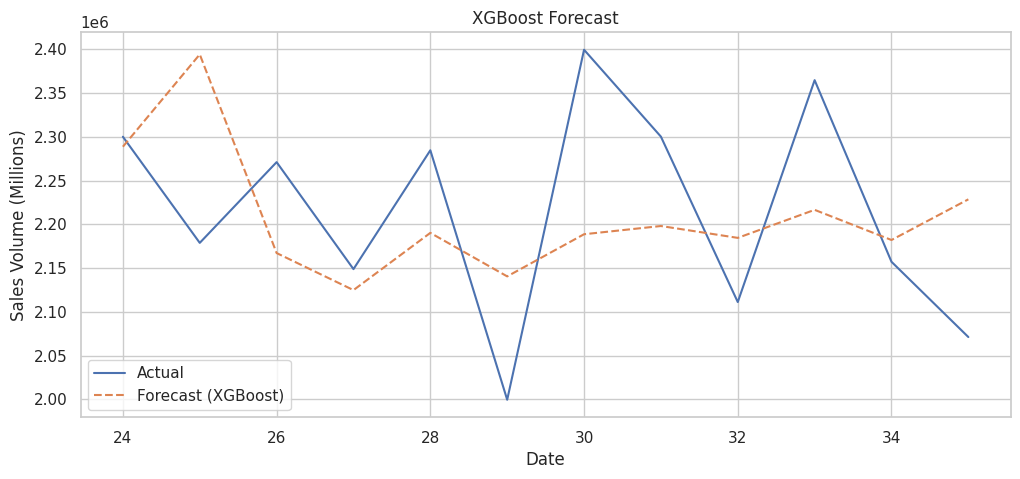

XGBoost RMSE: 127262.96605061505


In [17]:
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)
preds = model_xgb.predict(X_test)


# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


In [18]:
# XGBoost metrics
mse_xgb = mean_squared_error(y_test, preds)
mae_xgb = mean_absolute_error(y_test, preds)
r2_xgb = r2_score(y_test, preds)

print(f"XGBoost - MSE: {mse_xgb:.2f}, MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost - MSE: 16195862528.00, MAE: 108918.09, R²: -0.17


## LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


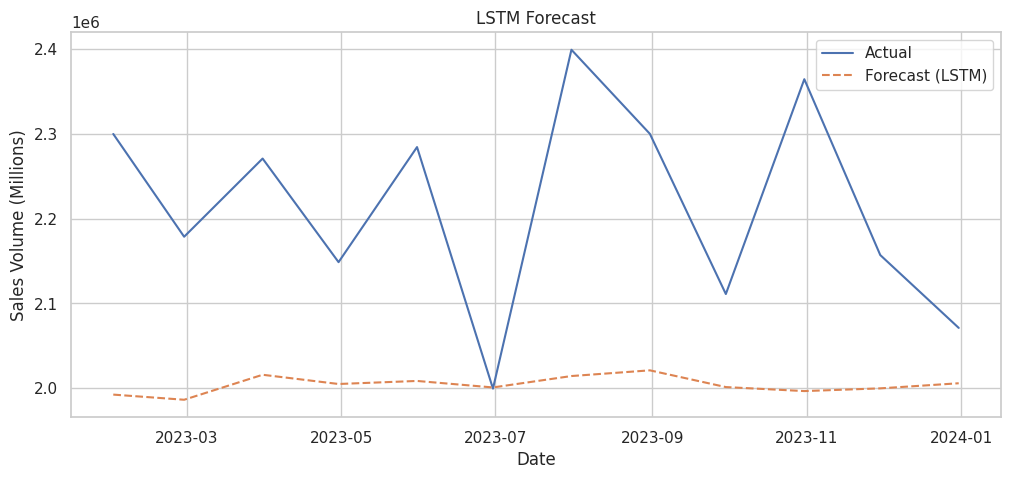

In [19]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# ... (your existing code for data loading and feature engineering) ...

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences
def create_sequences_lstm(X, y, seq_len=12):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_lstm, y_lstm = create_sequences_lstm(X_scaled, y_scaled)

# Train-test split
X_train_lstm, X_test_lstm = X_lstm[:-12], X_lstm[-12:]
y_train_lstm, y_test_lstm = y_lstm[:-12], y_lstm[-12:]

# Build LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, verbose=0)

# Predict
pred_scaled = model_lstm.predict(X_test_lstm)
pred_lstm1 = scaler_y.inverse_transform(pred_scaled)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index[-12:], monthly_sales.values[-12:], label='Actual')
plt.plot(monthly_sales.index[-12:], pred_lstm1, label='Forecast (LSTM)', linestyle='--')
plt.legend()
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

In [20]:
print(f"LSTM Tuned - MSE: {mean_squared_error(y_test_lstm, pred_lstm1):.2f}, "
      f"MAE: {mean_absolute_error(y_test_lstm, pred_lstm1):.2f}, "
      f"R²: {r2_score(y_test_lstm, pred_lstm1):.2f}")

LSTM Tuned - MSE: 4016067514882.16, MAE: 2003990.01, R²: -92842270063209.95


## Hyperparameter Tuning for XGBoost using GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV

# Perform grid search
grid_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                                    scoring='neg_mean_squared_error', n_iter=30, cv=3,
                                    verbose=1, n_jobs=-1, random_state=42)

grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
xgb_preds_tuned = best_xgb.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"XGBoost Tuned - MSE: {mean_squared_error(y_test, xgb_preds_tuned):.2f}, MAE: {mean_absolute_error(y_test, xgb_preds_tuned):.2f}, R²: {r2_score(y_test, xgb_preds_tuned):.2f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBoost Tuned - MSE: 15155885056.00, MAE: 110163.25, R²: -0.10


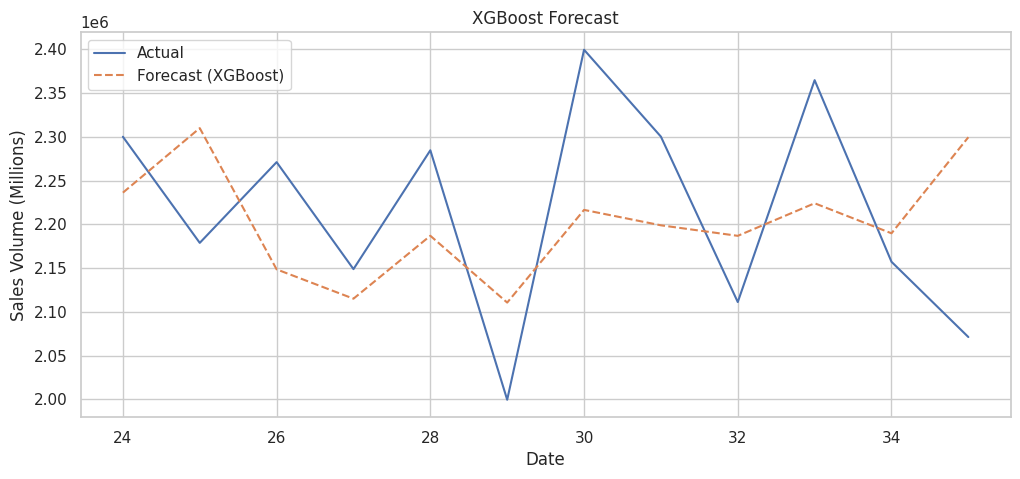

In [22]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_preds_tuned, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

## Improve XGBoost Tuning with RandomizedSearchCV

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Random search setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
random_search.fit(X_train, y_train)

# Best tuned model
best_xgb_tuned = random_search.best_estimator_

# Predict and evaluate
xgb_preds_best = best_xgb_tuned.predict(X_test)

print(f"\n📊 XGBoost (Random Search)")
print(f"MSE : {mean_squared_error(y_test, xgb_preds_best):.2f}")
print(f"MAE : {mean_absolute_error(y_test, xgb_preds_best):.2f}")
print(f"R²  : {r2_score(y_test, xgb_preds_best):.2f}")

# Display best parameters
print("\nBest Parameters:")
print(random_search.best_params_)

# {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

# {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}



Fitting 3 folds for each of 30 candidates, totalling 90 fits

📊 XGBoost (Random Search)
MSE : 15937683456.00
MAE : 112376.77
R²  : -0.15

Best Parameters:
{'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


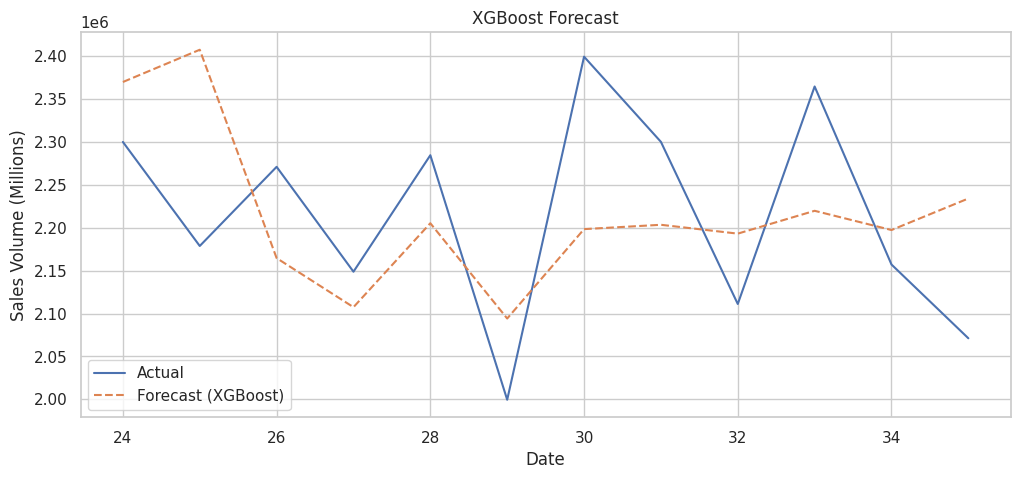

In [24]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_preds_best, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

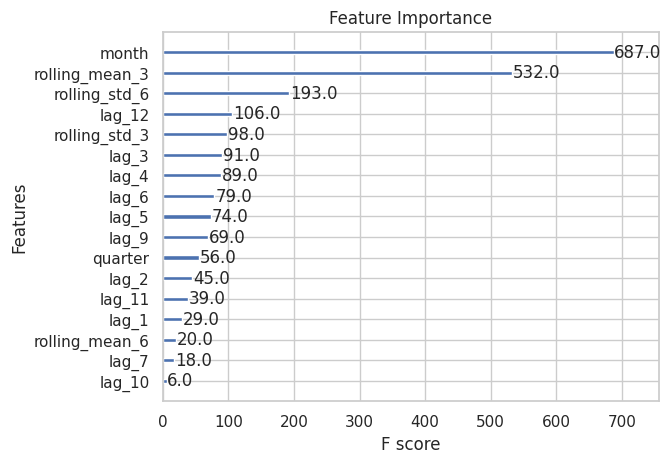

In [25]:
xgb.plot_importance(best_xgb_tuned)
plt.title("Feature Importance")
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

# Manually specified best parameters
manual_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'learning_rate': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.6
}

# Create and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **manual_params)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
preds = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Output evaluation
print(f"\n📊 XGBoost (Manual Params)")
print(f"RMSE : {np.sqrt(mse):.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.2f}")
print(f"Params used: {manual_params}")



📊 XGBoost (Manual Params)
RMSE : 101458.64
MAE  : 81660.91
R²   : 0.26
Params used: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.5, 'subsample': 0.8, 'colsample_bytree': 0.6}


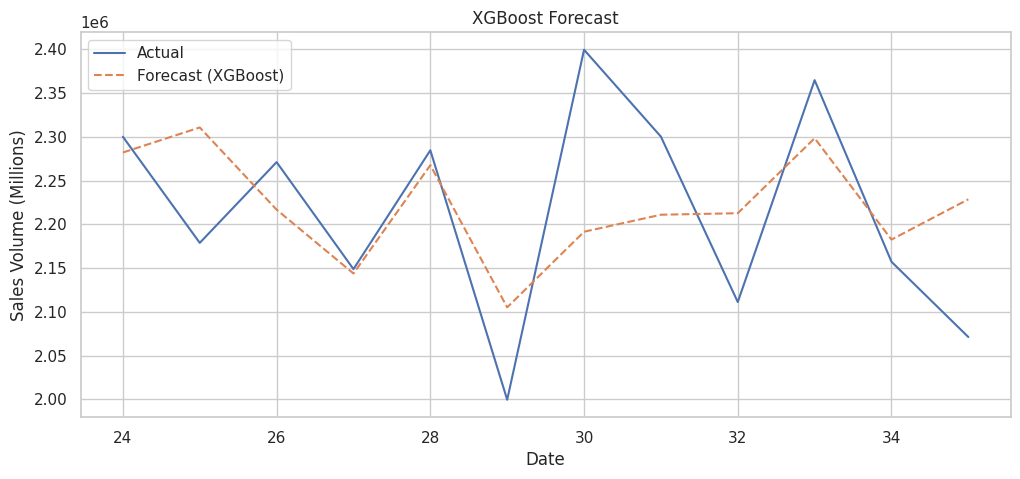

In [27]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, preds, label='Forecast (XGBoost)', linestyle='--')
plt.legend()
plt.title('XGBoost Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

# Model Stacking

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare the stacked features (predictions from ARIMA, XGBoost, LSTM)
# X_stack = np.column_stack([y_pred_arima, preds, pred_lstm])
X_stack = np.column_stack([c, preds, pred_lstm])

# Train a meta-learner (Linear Regression in this case)
meta_model = LinearRegression()
meta_model.fit(X_stack, y_test)  # Train on the stacked predictions

# Make predictions with the meta-model
stacked_preds = meta_model.predict(X_stack)

# Evaluate the stacked model
print("\n📊 Stacked Model Performance")
print("----------------------------")
print("Stacked MSE:", mean_squared_error(y_test, stacked_preds))
print("Stacked MAE:", mean_absolute_error(y_test, stacked_preds))
print("Stacked R²:", r2_score(y_test, stacked_preds))



📊 Stacked Model Performance
----------------------------
Stacked MSE: 4162308262.8854604
Stacked MAE: 50705.11547961272
Stacked R²: 0.6989844813102097


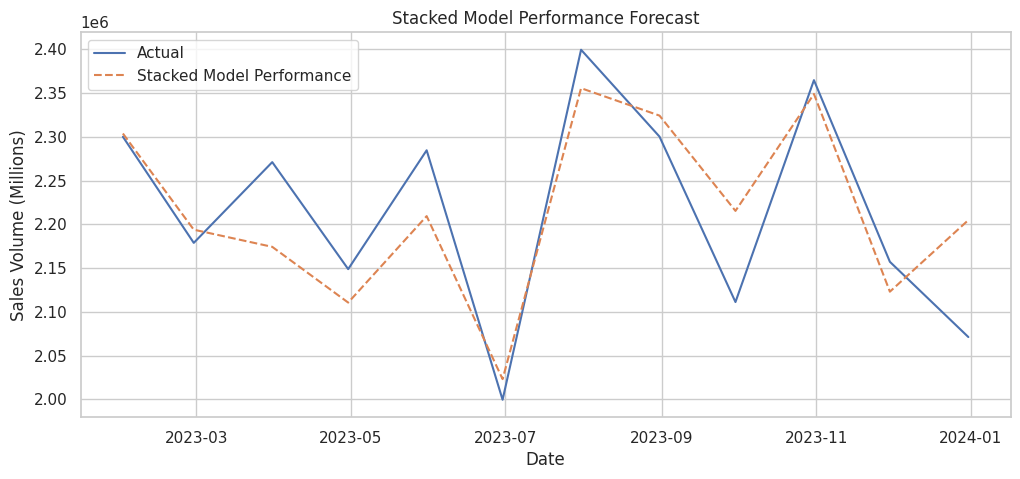

In [29]:
# Plot
plt.figure(figsize=(12,5))
plt.plot(monthly_sales.index[-12:], y_test, label='Actual') # Use monthly_sales.index[-12:] for time index
plt.plot(monthly_sales.index[-12:], stacked_preds, label='Stacked Model Performance', linestyle='--')
plt.legend()
plt.title('Stacked Model Performance Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Volume (Millions)')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get feature importance (coefficients)
# importance = meta_model.coef_

# # Get feature names (assuming X_stack was created with meaningful column names)
# # If X_stack doesn't have column names, you'll need to define them manually
# feature_names = ['ARIMA', 'XGBoost', 'LSTM']

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# plt.bar(feature_names, importance)
# plt.title("Feature Importance in Stacked Model")
# plt.xlabel("Features")
# plt.ylabel("Importance (Coefficient)")
# plt.show()

# Generate Future Forecasts

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


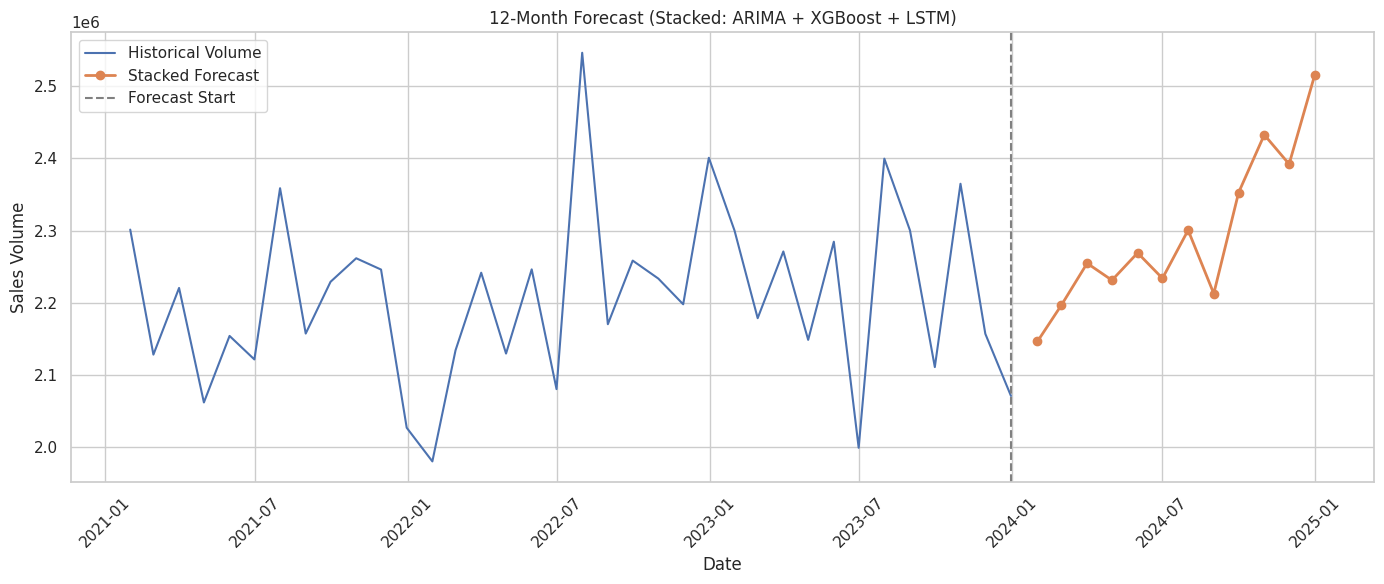

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense

# === STEP 1: Prepare Univariate LSTM Data ===
data = monthly_sales[['Volume']].values
scaler_uni = MinMaxScaler()
data_scaled = scaler_uni.fit_transform(data)

timesteps = 12
X_uni, y_uni = [], []
for i in range(timesteps, len(data_scaled)):
    X_uni.append(data_scaled[i-timesteps:i])
    y_uni.append(data_scaled[i])
X_uni, y_uni = np.array(X_uni), np.array(y_uni)

# === STEP 2: Train LSTM ===
model_lstm_uni = Sequential()
model_lstm_uni.add(LSTM(units=50, activation='relu', input_shape=(X_uni.shape[1], 1)))
model_lstm_uni.add(Dense(1))
model_lstm_uni.compile(optimizer='adam', loss='mse')
model_lstm_uni.fit(X_uni, y_uni, epochs=30, verbose=0)

# === STEP 3: LSTM Forecast for Past 12 (for stacking training) ===
X_last12 = X_uni[-12:]
pred_lstm_scaled_train = model_lstm_uni.predict(X_last12, verbose=0)
pred_lstm_train = scaler_uni.inverse_transform(pred_lstm_scaled_train).flatten()

# === STEP 4: ARIMA and XGBoost Forecasts for Past 12 ===
arima_fitted_values = model_fit.fittedvalues[-12:].values
xgb_pred_train = model_xgb.predict(df_feat.drop(columns=['Order_Date', 'Volume'], errors='ignore')).flatten()
xgb_pred_train = xgb_pred_train[-12:]

# === STEP 5: Train Meta-Model ===
stacked_X_train = np.column_stack([arima_fitted_values, xgb_pred_train, pred_lstm_train])
stacked_y_train = monthly_sales['Volume'].values[-12:]

scaler_meta = StandardScaler()
stacked_X_train_scaled = scaler_meta.fit_transform(stacked_X_train)

meta_model = LinearRegression()
meta_model.fit(stacked_X_train_scaled, stacked_y_train)

# === STEP 6: Forecast Next 12 Using Base Models ===

## ARIMA future
future_arima = model_fit.forecast(steps=12)

## XGBoost future
future_xgb = []
latest_features = df_feat.iloc[-1:].copy()
for _ in range(12):
    X_future = latest_features.drop(columns=['Order_Date', 'Volume'], errors='ignore')
    pred = model_xgb.predict(X_future)[0]
    future_xgb.append(pred)

    for lag in range(12, 1, -1):
        latest_features[f'lag_{lag}'] = latest_features[f'lag_{lag - 1}']
    latest_features['lag_1'] = pred
    latest_features['rolling_mean_3'] = np.mean([latest_features[f'lag_{i}'] for i in range(1, 4)])
    latest_features['rolling_mean_6'] = np.mean([latest_features[f'lag_{i}'] for i in range(1, 7)])
    latest_features['rolling_std_3'] = np.std([latest_features[f'lag_{i}'] for i in range(1, 4)])
    latest_features['rolling_std_6'] = np.std([latest_features[f'lag_{i}'] for i in range(1, 7)])

## LSTM future
lstm_input = X_uni[-1:]
future_lstm = []
for _ in range(12):
    pred_scaled = model_lstm_uni.predict(lstm_input, verbose=0)
    pred_unscaled = scaler_uni.inverse_transform(pred_scaled)[0][0]
    future_lstm.append(pred_unscaled)

    new_input = pred_scaled.reshape(1, 1, 1)
    lstm_input = np.concatenate([lstm_input[:, 1:, :], new_input], axis=1)

# === STEP 7: Stacked Forecast ===
stacked_X_future = np.column_stack([future_arima, future_xgb, future_lstm])
stacked_X_future_scaled = scaler_meta.transform(stacked_X_future)
stacked_forecast = meta_model.predict(stacked_X_future_scaled)

# === STEP 8: Plot ===
last_date = monthly_sales.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index, monthly_sales['Volume'], label='Historical Volume')
plt.plot(future_dates, stacked_forecast, label='Stacked Forecast', marker='o', linewidth=2)
plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title("12-Month Forecast (Stacked: ARIMA + XGBoost + LSTM)")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Synthetic Time Series Data




In [ ]:
import pandas as pd
import numpy as np

def generate_synthetic_series(start='2020-01-01', periods=60, freq='MS'):
    np.random.seed(42)
    date_range = pd.date_range(start=start, periods=periods, freq=freq)
    trend = np.linspace(100, 200, periods)
    seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, periods))
    noise = np.random.normal(scale=5, size=periods)
    volume = trend + seasonality + noise
    return pd.DataFrame({'Date': date_range, 'Volume': volume}).set_index('Date')

synthetic_data = generate_synthetic_series()

synthetic_data.plot(title="Synthetic Sales Volume (Trend + Seasonality + Noise)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Time vector
time = np.arange(0, 200)

# Synthetic time series: sine wave + noise
synthetic_series = np.sin(0.1 * time) + np.random.normal(scale=0.3, size=len(time))

# Plot it
plt.figure(figsize=(10, 4))
plt.plot(time, synthetic_series, label="Synthetic Series")
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
